In [1]:
import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")

os.makedirs("output/plots", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)





In [2]:
# Extract only the needed columns from the large file using pandas
raw_path = "C:\\Users\\HP\Downloads\\stackoverflow-dask-analysis2024\\data\\raw\\survey_results_public.csv"
save_path = "C:\\Users\\HP\\Downloads\\stackoverflow-dask-analysis2024\\data\\raw\\survey_results_schema.csv"

selected_cols = [
    'Country',
    'EdLevel',
    'Employment',
    'DevType',
    'YearsCodePro',
    'LanguageHaveWorkedWith',
    'ConvertedCompYearly'
]

df_raw = pd.read_csv(raw_path, usecols=selected_cols)
df_raw.to_csv(save_path, index=False)



In [3]:
# Load the smaller cleaned CSV using Dask
df = dd.read_csv(save_path, dtype=str, assume_missing=True)

# Load the schema (optional)
schema = pd.read_csv("C:\\Users\\HP\\Downloads\\stackoverflow-dask-analysis2024\\data\\raw\\survey_results_schema.csv")
schema.head()



,Employment,EdLevel,YearsCodePro,DevType,Country,LanguageHaveWorkedWith,ConvertedCompYearly
0,"Employed, full-time",Primary/elementary school,NaN,NaN,United States of America,NaN,NaN
1,"Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",17,"Developer, full-stack",United Kingdom of Great Britain and Northern I...,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,NaN
2,"Employed, full-time","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,Developer Experience,United Kingdom of Great Britain and Northern I...,C#,NaN
3,"Student, full-time",Some college/university study without earning ...,NaN,"Developer, full-stack",Canada,C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...,NaN
4,"Student, full-time","Secondary school (e.g. American high school, G...",NaN,"Developer, full-stack",Norway,C++;HTML/CSS;JavaScript;Lua;Python;Rust,NaN


In [4]:
# Step 1: Standardize text columns
df['Country'] = df['Country'].str.strip().str.title()

# Step 2: Clean years of professional coding
df['YearsCodePro'] = df['YearsCodePro'].replace({
    'Less than 1 year': '0',
    'More than 50 years': '51'
})
df['YearsCodePro'] = dd.to_numeric(df['YearsCodePro'], errors='coerce')

# Step 3: Clean salary
df['ConvertedCompYearly'] = dd.to_numeric(df['ConvertedCompYearly'], errors='coerce')


In [5]:
# Drop rows with missing country or salary
df = df.dropna(subset=['Country', 'ConvertedCompYearly'])

# Drop rows with too many missing values
df = df.dropna(thresh=4)

# Remove outlier salaries
df = df[(df['ConvertedCompYearly'] > 1000) & (df['ConvertedCompYearly'] < 500000)]

# Drop duplicates
df = df.drop_duplicates()

# Trigger Dask computation and convert to Pandas
df = df.compute()
df.head()


,Employment,EdLevel,YearsCodePro,DevType,Country,LanguageHaveWorkedWith,ConvertedCompYearly
72,"Employed, full-time;Student, full-time;Indepen...","Secondary school (e.g. American high school, G...",1,Data scientist or machine learning specialist,Pakistan,Assembly;Bash/Shell (all shells);C;C++;HTML/CS...,7322.0
374,"Employed, full-time","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",6,Academic researcher,Austria,C;C++;Fortran;MATLAB;Python;SQL,30074.0
379,"Employed, full-time","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,Data scientist or machine learning specialist,Turkey,JavaScript;Julia;Python;SQL;TypeScript,91295.0
385,"Independent contractor, freelancer, or self-em...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",17,"Developer, back-end",France,Python,53703.0
389,"Employed, full-time;Student, part-time",Some college/university study without earning ...,7,Student,United States Of America,HTML/CSS;JavaScript;Python;SQL;TypeScript,110000.0


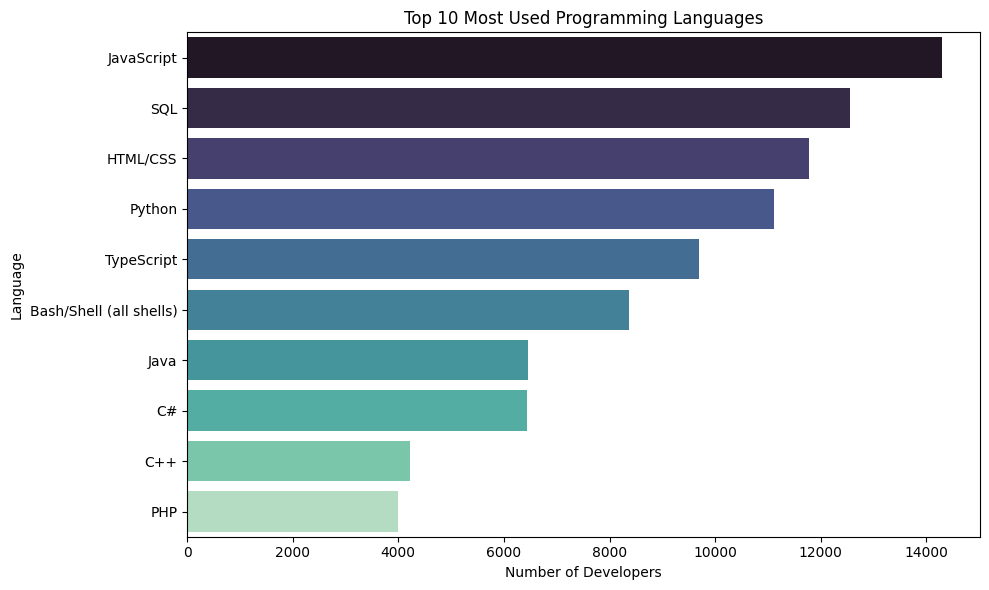

In [6]:
from collections import Counter

langs_series = df["LanguageHaveWorkedWith"].dropna().str.split(";")
langs_flat = [lang for sublist in langs_series for lang in sublist]
lang_counts = Counter(langs_flat)
lang_df = pd.DataFrame(lang_counts.most_common(10), columns=["Language", "Count"])

plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Language", data=lang_df, palette="mako")
plt.title("Top 10 Most Used Programming Languages")
plt.xlabel("Number of Developers")
plt.ylabel("Language")
plt.tight_layout()
plt.savefig("output/plots/top_languages.png")
plt.show()



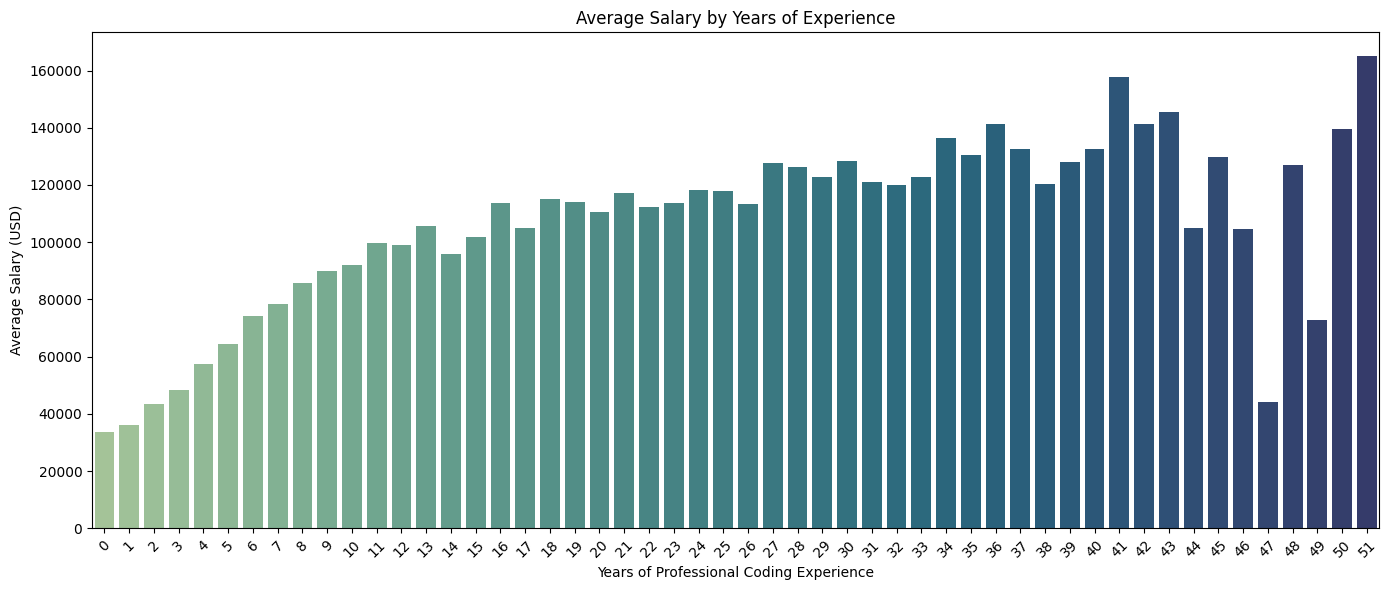

In [7]:
# Group by experience and calculate average salary
exp_salary = df.groupby("YearsCodePro")["ConvertedCompYearly"].mean().dropna().sort_index()

# Convert index to string (for proper categorical plotting)
exp_salary.index = exp_salary.index.astype(str)

# Select only numeric years to avoid confusion with 'Less than 1 year' or 'More than 50 years'
exp_salary = exp_salary[exp_salary.index.str.replace('.', '', 1).str.isnumeric()]
exp_salary = exp_salary.sort_index(key=lambda x: x.astype(float))

# Plotting as bar chart
plt.figure(figsize=(14, 6))
sns.barplot(x=exp_salary.index, y=exp_salary.values, palette="crest")
plt.title("Average Salary by Years of Experience")
plt.xlabel("Years of Professional Coding Experience")
plt.ylabel("Average Salary (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("output/plots/salary_by_experience_bar.png")
plt.show()


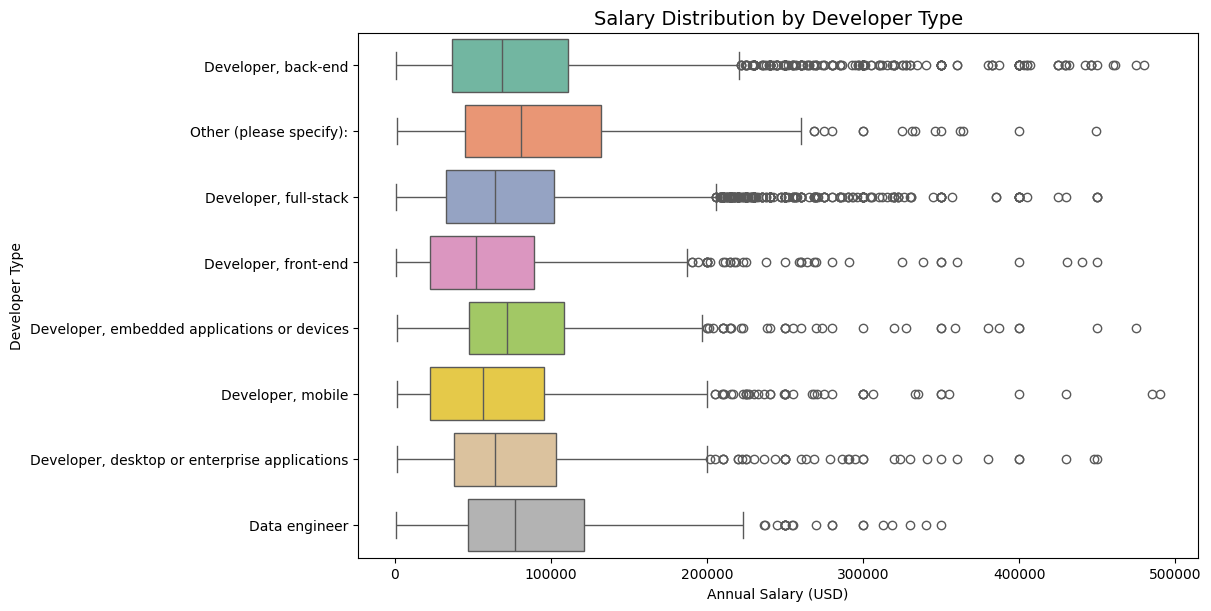

In [8]:

# Filter required columns and drop missing values (only if not done before)
df_dev = df[['DevType', 'ConvertedCompYearly']].dropna()

# Optional: Filter top 8 Developer Types to make the plot more readable
top_dev_types = df_dev['DevType'].value_counts().nlargest(8).index
df_dev = df_dev[df_dev['DevType'].isin(top_dev_types)]

# Set figure size and layout
plt.figure(figsize=(12, 6), constrained_layout=True)

# Create box plot
sns.boxplot(
    data=df_dev,
    x="ConvertedCompYearly",
    y="DevType",
    palette="Set2"
)

# Titles and labels
plt.title("Salary Distribution by Developer Type", fontsize=14)
plt.xlabel("Annual Salary (USD)")
plt.ylabel("Developer Type")

# Show plot
plt.show()

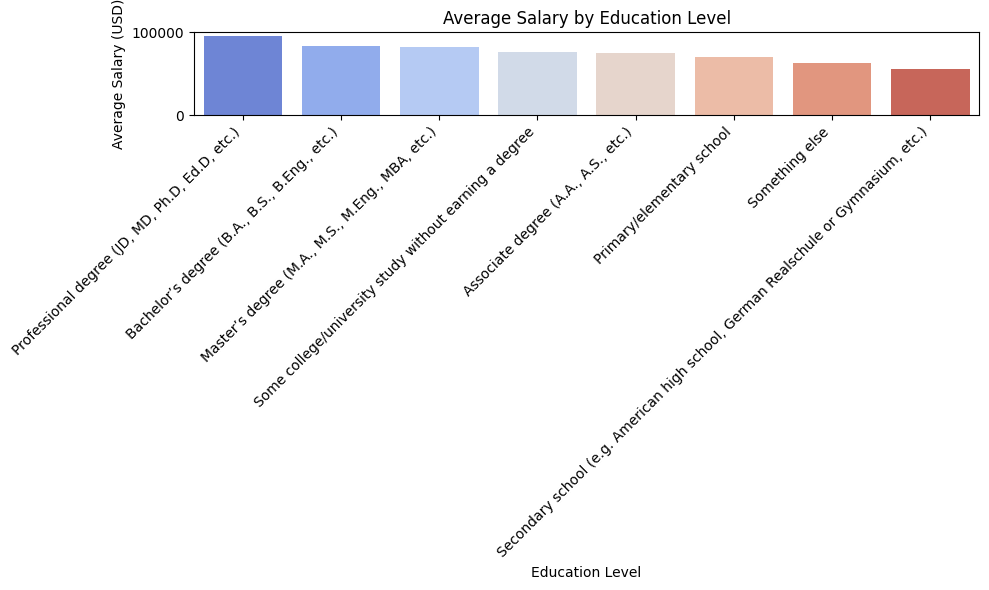

In [9]:
# Group the data by Education Level and calculate the mean salary
edu_salary = df.groupby("EdLevel")["ConvertedCompYearly"].mean().sort_values(ascending=False)

# Plot as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=edu_salary.index, y=edu_salary.values, palette="coolwarm")

# Styling
plt.title("Average Salary by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Average Salary (USD)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [10]:
# Project Summary by Ashutosh Choudhury 
# In this project, we performed a large-scale analysis on the Stack Overflow Developer Survey 2024 dataset using Dask.
# We cleaned and filtered the data, handled missing values and outliers.
# created insightful visualizations such as salary distribution by country, education level, and developer type. 
# The project demonstrates real-world skills in data preprocessing, visualization, and big data handling with Dask.
